# Tuto\#1 How to get the histograms of the data and the models

GRIP aims at fit the histograms of the data instead of the data themselves.

GRIP generates synthetic probability density function from an estimator of the null depth until the modelled distribution fit the histogram.

This tutorial explains how to use GRIP to:
- Load the data
- Organise them into a histogram
- Display the histogram
- Plot a model of the histogram over it

## Load the data

We will use data from the LBTI nuller, located in the folder `./tutorials/dataset/`.

Save the folder in the same place as this notebook.
The folder contains two files:
- UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5
- UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5

The first one contains the science data, and the second one is the thermal background, which is the dominant noise across the instrumental chain.
Raw data for NULL data initially comes from several acquired files (null, photometry of beam 1, photometry of beam 2), they have been pre-processed then packed into a single HDF5.
The exact same process and pre-processing happens to the BCKG data.

### Explore the content
Let's first explore the content of the files.

In [1]:
import h5py
import numpy as np
import os

datafolder = 'dataset/'
darkfolder = datafolder
save_path = 'results/'

In [2]:
data_file = h5py.File(datafolder+'UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5')
print('NULL file contains:', data_file.keys())

data_file = h5py.File(datafolder+'UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5')
print('BCKG file contains:', data_file.keys())

NULL file contains: <KeysViewHDF5 ['Iminus1', 'intraphase_avg', 'intraphase_rms', 'p1', 'p2', 'wl_scale']>
BCKG file contains: <KeysViewHDF5 ['Iminus1', 'p1', 'p2', 'wl_scale']>


We see that the NULL file contains the time-sequences of :
- the flux collected by the camera from the null fringe (*Iminus1*),
- the flux collected when only the beam 1 was active (*p1*), then beam 2 (*p2*)
- the wavelength of the data (*wl_scale*)
The LBTI also has a fringe tracker **operating at 2.2 $\mu$m**, the average average value (*intraphase_avg*) and the standard deviation (*intraphase_rms*) of the differential piston happening during one exposure time are also recorded.

The BCKG file contains the time-sequences of the thermal background acquired during:
- the acquisition of the null depth (*Iminus1*)
- the acquisition of the photometry of beam 1 (*p1*)
- the acquisition of the photometry of beam 2 (*p2*)
- the wavelength of the data (*wl_scale*)

The wavelength scale is here to check we can combine data from the same wavelength.

### Load the data with GRIP
Let's load the data with GRIP.
The exploration above allows to identify the data to use in the model of the instrument (i.e. the estimator of the null depth).
In the case of the LBTI, the instrument model of the null depth is as follows (Defrère+, 2016):

$ N = \frac{I_{-}}{I_{+}} $

with $I_{-} = I_1 + I_2 + 2 \sqrt{I_1 I_2} |V| \cos(\Delta \phi) (1 - 0.5\sigma^2_\epsilon + 0.125 \sigma^4_\epsilon) + B$

- $I_x$ is the intensity of the output
- $\Delta_\phi$ is the phase of the fringe due to atmospheric turbulence, the phase is centered around $\pi$
- $\sigma_\epsilon$ is the standard deviation of the phase within an exposure time, thus doing fringe blurring
- $B$ is the thermal background

The LBTI does not record the bright fringe, the paper uses an ad hoc expression:

$I_{+} = I_1 + I_2 + 2 \sqrt{I_1 I_2}$

The parameters to fit are:
- the astrophysical null depth ($N_a = \frac{1-|V|}{1+|V|}$)
- the location $\mu$ and the scale $\sigma$ of the normal distribution describing the statistics of the fluctuations of phase $\Delta \phi$.

From this model, it is clear we need the following quantities from the NULL file:
- *Iminus1*
- *p1*
- *p2*
- *wl_scale*
- *intraphase_rms*

And we need all the data from the BCKG file.

We load the data from the NULL and BCKG files with the function: ``load_data(data, kw_to_extract, wl_edges)``.

- ``data`` is the **list** of the data files to load
- ``kw_to_extract`` is the **list** of keywords to extract from the files
- ``wl_edges`` is the tuple of the minimum and maximum value of the wavelengths we want to extract

The last argument is pointless here because the LBTI does not provide spectrally-dispersed data.
However, others do, and large quantities of data may be loaded to maximise the efficiency of the statistics.
Pruning the wavelength at the beginning allows memory to be saved.

In [3]:
import grip
try:
    import cupy as cp # To use the GPU to speed up the process
    onGpu = True
except ModuleNotFoundError:
    import numpy as cp # If no GPU, we load numpy again with the same acronym to still use the functions
    onGpu = False

wl_min, wl_max = 11000, 11200
dark_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5']
data_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5']
dark = grip.load_data(dark_list, ['wl_scale', 'Iminus1', 'p1', 'p2'], (wl_min, wl_max), 'hdf5')
data = grip.load_data(data_list, ['wl_scale', 'Iminus1', 'p1', 'p2', 'intraphase_rms'], (wl_min, wl_max), 'hdf5')

dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5
dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5


Let's dispatch the content of ``dark`` and ``data`` into different variables.

In [4]:
wl_scale = data['wl_scale']

dark_IA, dark_IB = dark['p1'], dark['p2']
dark_Iminus = dark['Iminus1']

Iminus = data['Iminus1']
data_IA, data_IB = data['p1'], data['p2']

print('Shape of the wavelength array:', wl_scale.shape)
print(data_IA.shape, data_IB.shape, Iminus.shape)
print(dark_IA.shape, dark_IB.shape, dark_Iminus.shape)

Shape of the wavelength array: (1,)
(1, 984) (1, 984) (1, 984)
(1, 990) (1, 990) (1, 990)


**Note that every spectral quantities must be an array which the first axis has the same size as the wavelength scale**.

## Get the histogram
We calculate the null depth then the histogram.

In [5]:
# Calculate the null depth
Iplus = data_IA + data_IB + 2 * (data_IA * data_IB)**0.5 # Using the estimator above
data_null = Iminus / Iplus # Calculated null depth

# Get the histogram
bin_bounds = (-0.01, 0.1) # Minimum and maximum values of the bins of the histogram
normed=True # We want to normalise the histogram by its sum

null_axis, null_pdf, null_pdf_err, sz = grip.compute_data_histogram(data_null, \
                                                          bin_bounds, \
                                           wl_scale, normed=normed)

print('Shape of the bin array', null_axis.shape)
print('Shape of the pdf array and its uncertainties one', null_pdf.shape, null_pdf_err.shape)

Shape of the bin array (1, 32)
Shape of the pdf array and its uncertainties one (1, 31) (1, 31)


**Once again, notice these arrays are 2D, the first axis is the wavelength.**

## Generate a model of the histogram
We are starting a hard bite. Bear with me.

Let's recall the model of the instrument, it will be used to create fake sequence of null depth which will give the model to fit to the data.
I have rewritten it with the quantities we have and their alledged dependency with the wavelength.

$ N = \frac{I_{-}}{I_{+}} $

$I_{-}(\lambda) =I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)} |V| \cos(\frac{2\pi}{\lambda} \Delta OPD) (1 - 0.5\sigma^2_\epsilon + 0.125 \sigma^4_\epsilon) + B(\lambda)$

$I_{+}(\lambda) = I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)}$

It is important to identify what can be modeled as a random value from a deterministic parameter.

Here, it is obvious, everything but $V$ (the visibility) is a random value. $V$ is determined by the stellar properties, the variations of the photometries and phase are unpredictable like the thermal background and are considered as random values.
Their statistical distributions will be used to model the histogram.
In this model, we also assume all the random values are independent.

We get their cumulative density functions which will allow to generate random values in the model.

### Get the CDF of the photometries
The photometries are random values and depend on the wavelength.
However, it is reasonable to think the statistical distribution of the photometry is independant from the wavelength.

GRIP allows to split the photometry in two components:
- the spectrum (constant)
- the integrated flux over the spectral bandwidth (random value)

This distinction is particularly relevant in the case of a nuller with guided optics (e.g. optical fiber, integrated-optics...)

In [6]:
injection, spectra = grip.get_injection_and_spectrum(
    data_IA, data_IB, wl_scale, (wl_min, wl_max))

print('Shape of the spectra (1st axis is p1 and p2)', spectra.shape)
print('Shape of the integrated fluxe (1st axis is p1 and p2)', injection.shape)

Shape of the spectra (1st axis is p1 and p2) (2, 1)
Shape of the integrated fluxe (1st axis is p1 and p2) (2, 984)


Let's assume the fluctuation of the photometries of beams 1 and 2 are mostly due to the thermal background.
Thus the "unbiased" photometries are constant at their average values.

GRIP provides a function to bin nd-arrays.

In [7]:
nb_frames_binning_photometry = -1 # Bin over all the sample
injection, dummy = grip.binning(
    injection, nb_frames_binning_photometry, axis=1, avg=True)

Then we get their CDFs

In [8]:
data_IA_axis = cp.linspace(injection[0].min(), injection[0].max(),
                           np.size(np.unique(injection[0])),
                           dtype=cp.float32)
cdf_data_IA = grip.computeCdf(data_IA_axis, injection[0], 'cdf', True)
cdf_data_IA = cp.array(cdf_data_IA, dtype=cp.float32)

data_IB_axis = cp.linspace(injection[1].min(), injection[1].max(),
                           np.size(np.unique(injection[1])),
                           dtype=cp.float32)
cdf_data_IB = grip.computeCdf(data_IB_axis, injection[1], 'cdf', True)
cdf_data_IB = cp.array(cdf_data_IB, dtype=cp.float32)

### Get the CDF of the piston RMS
The phase variation within an exposure time is measured at 2.2 $\mu$m while the null is at 11.1 $\mu$m.
We need to convert this phase from 2.2 to 11.1 $\mu$m and reshape the array containing the values appropriately (i.e. making the first axis equal to the shape of the wavelength).
Finally, we get the CDF.

In [9]:
sigma_eps = data['intraphase_rms']
sigma_eps = np.radians(sigma_eps)
sigma_eps *= 2200 / wl_scale
sigma_eps = sigma_eps.reshape((1, -1))
sigma_eps_axis, sigma_eps_cdf = grip.get_dark_cdf(sigma_eps, wl_scale)

### Get the CDF of the thermal background

In [10]:
std_dark_Iminus = np.std(dark_Iminus)
dark_Iminus -= np.mean(dark_Iminus, 1, keepdims=True) # The model is better when the data are forced to be of average 0
    
dark_Iminus_axis, dark_Iminus_cdf = grip.get_dark_cdf(
    dark_Iminus, wl_scale)

## Create the model of the histogram

GRIP reproduces the histogram of data through a Monte-carlo approach.
Hence the necessity to identify what is a random value from the data and the model to use, as seen above.

The function we will use here is ``histogram_tools.create_histogram_model(params_to_fit, xbins, wl_scale0, instrument_model, instrument_args, rvu_forfit, cdfs, rvus, **kwargs)``, with the following parameters:
- `params_to_fit`: list of values of the parameters to fit, which can be used to run the model with arbitrary values
- `xbins`: x-axis of the histogram of size `nbins+1`
- `wl_scale0`: the wavelength scale (array)
- `instrument_model`: the function of the estimator of the null, taken from GRIP or custom-made, in which the Monte-Carlo is run
- `instrument_args`: tuple of arguments to run the instrument model
- `rvu_forfit`: one sequence of uniformly distributed random values for the parameters to fit
- `cdfs`: list of the CDFs of the random values of the instrument model
- `rvus`: list of sequences of uniformly distributed random values to be injected through the CDFs
- `kwargs`: see documentation

We are going to use the built-in LBTI nuller estimator in GRIP for `instrument_model`.

When running the Monte-Carlo, random values are generated from the CDFs in `cdfs`.
To do so, uniformly distributed random values are withdrawn by the algorithm, projected on the CDF to get random values following the PDF of the considered CDF.
If reproducibility is desired, the sequence of uniformly distributed random values can be set instead of being recreated every time `create_histogram_model` is called, by defining the input argument `rvus`.

`params_to_fit` is a list of 3 parameters: the self-calibrated null depth, the location ($\mu$) and scale ($\sigma$) parameters of a normal distribution used to generate one quantity in `instrument_model` (e.g. the OPD).

`rvu_forfit` is like `rvus` but for this normal distribution. The advantage during the fitting process is the sequence of random values is the same if the same couple of $\mu$ and $\sigma$ are called twice.

To sum up, having `rvu_forfit` AND `rvus` allow the `create_histogram_model` to give the exact same histogram for the exact same inputs.

In [11]:
rvu_opd = None # To generate RV reproducing the statistics of the OPD fluctuations
rvu_IA = None # To generate RV reproducing the statistics of the injection of beam A
rvu_IB = None # To generate RV reproducing the statistics of the injection of beam B
rvu_bg = [None]*wl_scale.size # To generate RV reproducing the statistics of the thermal background, per spectral channel
rvu_eps = [None]*wl_scale.size # To generate RV reproducing the statistics of the fringe blurring, per spectral channel

# Uncomment the lines below to play with "deterministic" Monte-Carlo
# rvu_opd = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IA = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IB = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_bg = cp.random.uniform(0, 1, size=(wl_scale0.size, n_samp_per_loop), dtype=cp.float32)
# rvu_eps = cp.random.uniform(0, 1, size=(wl_scale0.size, n_samp_per_loop), dtype=cp.float32)

# Embed all of the above in lists
rvus = [rvu_IA, rvu_IB, rvu_bg, rvu_eps]
cdfs = [(data_IA_axis, cdf_data_IA), (data_IB_axis, cdf_data_IB),\
        (dark_Iminus_axis, dark_Iminus_cdf), (sigma_eps_axis, sigma_eps_cdf)]

The number of samples generated by the Monte-Carlo process must also be defined.
And maybe the workstation does not have much memory, the solution is to chunk this number into smaller ones, run the MC process as many times and average the synthetic histograms.

In [12]:
n_samp_total = int(2e6)
n_samp_per_loop = int(1e6)
nloop = n_samp_total // n_samp_per_loop

Then the function `create_histogram_model` is called.
By default, it prints the number of times it has been called with the value of the parameters to fit (useful to monitor the fitting process and assess the reliability of the result).

In [13]:
na = 0.0063
mu_opd = 300 # in nm
sig_opd = 180 # in nm
initial_guess = [na, mu_opd, sig_opd]
initial_guess = np.array(initial_guess, dtype=np.float64)
spec_chan_width = 2600

instrument_constants = (spec_chan_width, np.pi) # Constant of the model: the spectral width of the instrument and the pi phase used to get the null fringe
out = grip.create_histogram_model(initial_guess, null_axis, wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus, \
                                  n_samp_per_loop=n_samp_per_loop, nloop=nloop)


(1, 0.0063, 300.0, 180.0)


The outputs of `create_histogram_model` is the model of the histograms and some useful diagnostic data.
Let's go through them.

The function returns `create_histogram_model`:
- the model of the histograms and some useful diagnostic data as a flattened array along the spectral axis
- secondary outputs of `instrument_model` (e.g. diagnostic info generated by this function)
- the sequence of random values generated by non-wavelength-dependent quantities
- the sequence of random values generated by wavelength-dependent quantities

In [14]:
synth_histo = out[0] # Flatten histogram along the wavelength axis.
diag = out[1][0]
diag = cp.array(diag)

if onGpu:
    diag = cp.asnumpy(diag)
    diag_opd = cp.asnumpy(cp.array(out[2][0][0][0]))
    diag_IA = cp.asnumpy(cp.array(out[2][0][0][1]))
    diag_IB = cp.asnumpy(cp.array(out[2][0][0][2]))
    diag_dkIA = cp.asnumpy(cp.array(out[3])[0,:,0])
    diag_dkIB = cp.asnumpy(cp.array(out[3])[0,:,1])
else:
    diag = cp.array(diag)
    diag_opd = out[2][0][0][0]
    diag_IA = out[2][0][0][1]
    diag_IB = out[2][0][0][2]
    diag_dkIA = np.array(out[3])[0,:,0]
    diag_dkIB = np.array(out[3])[0,:,1]    


We may also want to calculate the reduced $\chi^2$ for this specific model.

Let's called `calculate_chi2` to calculate the $\chi^2$ between `null_pdf` and the `synth_histo` by using the keyword `use_this_model`.

If `use_this_model=None`, `create_histogram_model` is called again, generating a new histogram, different (even slightly) from `synth_histo`.

In [15]:
uncertainties = np.zeros(3)
popt = (np.array([na, mu_opd, sig_opd]), np.ones((3, 3)))
extra_args = [null_pdf_err]
chi2 = grip.calculate_chi2(popt[0], null_pdf, grip.create_histogram_model, *extra_args, use_this_model=synth_histo)
print(chi2)

# If `synth_histo` is not used, we need to put more parameters in `extra_args` as indicated in the documentation:
extra_args = [null_pdf_err, null_axis] + [wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus]
chi22 = grip.calculate_chi2(popt[0], null_pdf, grip.create_histogram_model, *extra_args, n_samp_per_loop=n_samp_per_loop, nloop=nloop)
print(chi22)

1.6062620100292402
(2, 0.0063, 300.0, 180.0)
1.6383812932271322


## Plot the results
GRIP allows to plot the results in a nice way, despite the number of wavelength channels.

It also allows to plot the histograms of the diagnostic data.

### Plot the histogram of the null depth and its model
Let's use `plot_null_distributions(nb_rows_plot, wl_scale, text, null_axis, null_pdf, null_pdf_err, save_path, save_name, model=None, save_fig=True)`:
- nb_rows_plot: number of rows to display in one `plt.figure` instance (irrelevant when there is just one wavelength to display)
- `wl_scale`: the wavelength scale, used as a subplot title
- `null_axis`: the bin axis, each row of this array contains the bin-axis for one wavelength
- `null_pdf`: the histograms, same concept as `null_axis` regarding the wavelength axis
- `null_pdf_err`: the error bars, same concept as `null_axis` regarding the wavelength axis
- `save_path`: absolute or relative path to save the figure as a PNG 150 dpi
- `model`: model to overplot
- `save_fig`: save the figure in `save_path`


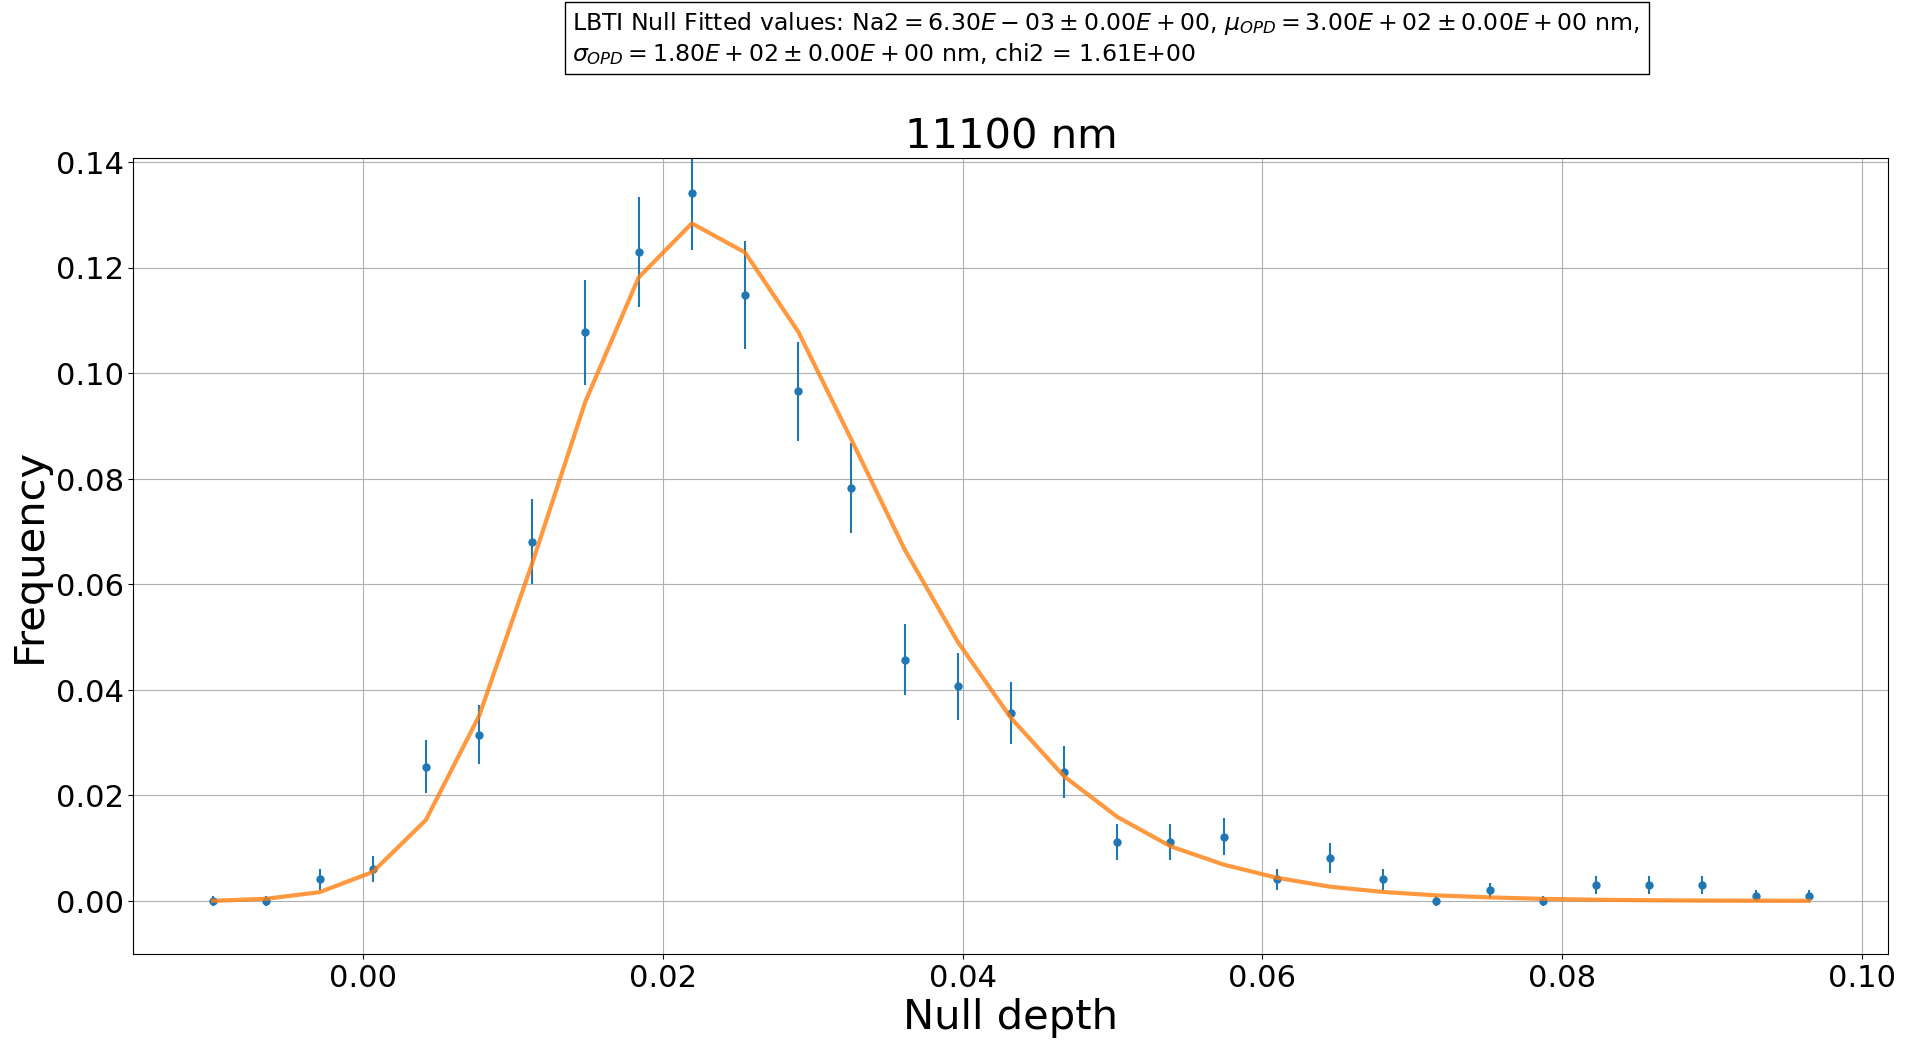

In [16]:
nb_rows_plot = 3
label_optimizer = 'chi2'
key = 'LBTI Null'
text_params = '%s ' % key+'Fitted values: ' +\
    'Na2$ = %.2E \pm %.2E$, ' % (na,
                                uncertainties[0]) +\
    r'$\mu_{OPD} = %.2E \pm %.2E$ nm, ' % (popt[0][1],
                                            uncertainties[1]) +\
    '\n' + r'$\sigma_{OPD} = %.2E \pm %.2E$ nm,' % (
        popt[0][2], uncertainties[2]) +\
    ' '+label_optimizer+' = %.2E ' % (chi2)
    
save_name = key + '_' + str(wl_min) + '-' + str(wl_max) + '_' + os.path.basename(datafolder[:-1])
grip.plot_null_distributions(nb_rows_plot, wl_scale, text_params, null_axis, null_pdf,\
                            null_pdf_err, save_path, save_name, model=synth_histo,\
                                save_fig=True)


### Plot diagnostic data
Similarly, it is possible to plot the histograms diagnostic data. It is extremely useful to know how the MC went through the model and the specified random quantities.

First, the histograms of the diagnostic data must be made.

In [17]:
liste_rv_interfminus = diag[:,0,:]
liste_rv_interfplus = diag[:,1,:]

histom = [np.histogram(Iminus[k], bins=int(
    Iminus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histom = [(elt[0][:-1], elt[1]) for elt in histom]

histom2 = [np.histogram(liste_rv_interfminus[k], bins=int(
    liste_rv_interfminus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histom2 = [(elt[0][:-1], elt[1]) for elt in histom2]

histop = [np.histogram(Iplus[k], bins=int(
    Iplus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histop = [(elt[0][:-1], elt[1]) for elt in histop]

histop2 = [np.histogram(liste_rv_interfplus[k], bins=int(
    liste_rv_interfplus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histop2 = [(elt[0][:-1], elt[1]) for elt in histop2]

histodkm = [np.histogram(dark['Iminus1'][k], bins=int(
    dark['Iminus1'][k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histodkm = [(elt[0][:-1], elt[1]) for elt in histodkm]


Then the plots can be displayed.

Let's start with the statistics of the nulled and anti-null signals.

GRIP allows to plot diagnostic data with `grip.plot_diag_spectral_data` if the data are wavelength dependant and `grip.plot_diag_nonspectral_data` if not.

These functions can plot an arbitrary number of quantities, with the markers and legend labels we want.

The data to plot must be a tuple, which contains one tuple per marker. Each element of the sub-tuple is the (x,y) data to plot.

The labels follow the same struture.

Let's see below: we store in `data_to_plot` the histograms we want to plot:
- `data_to_plot` is a tuple with three elements which are also tuples
- the tuple `(histom, histop)` are two data sets which will be plot with the same marker "."
- `histom` is a tuple-like objectif itself which contains the x- and y-data. The same applies for all the other elements of the tuple

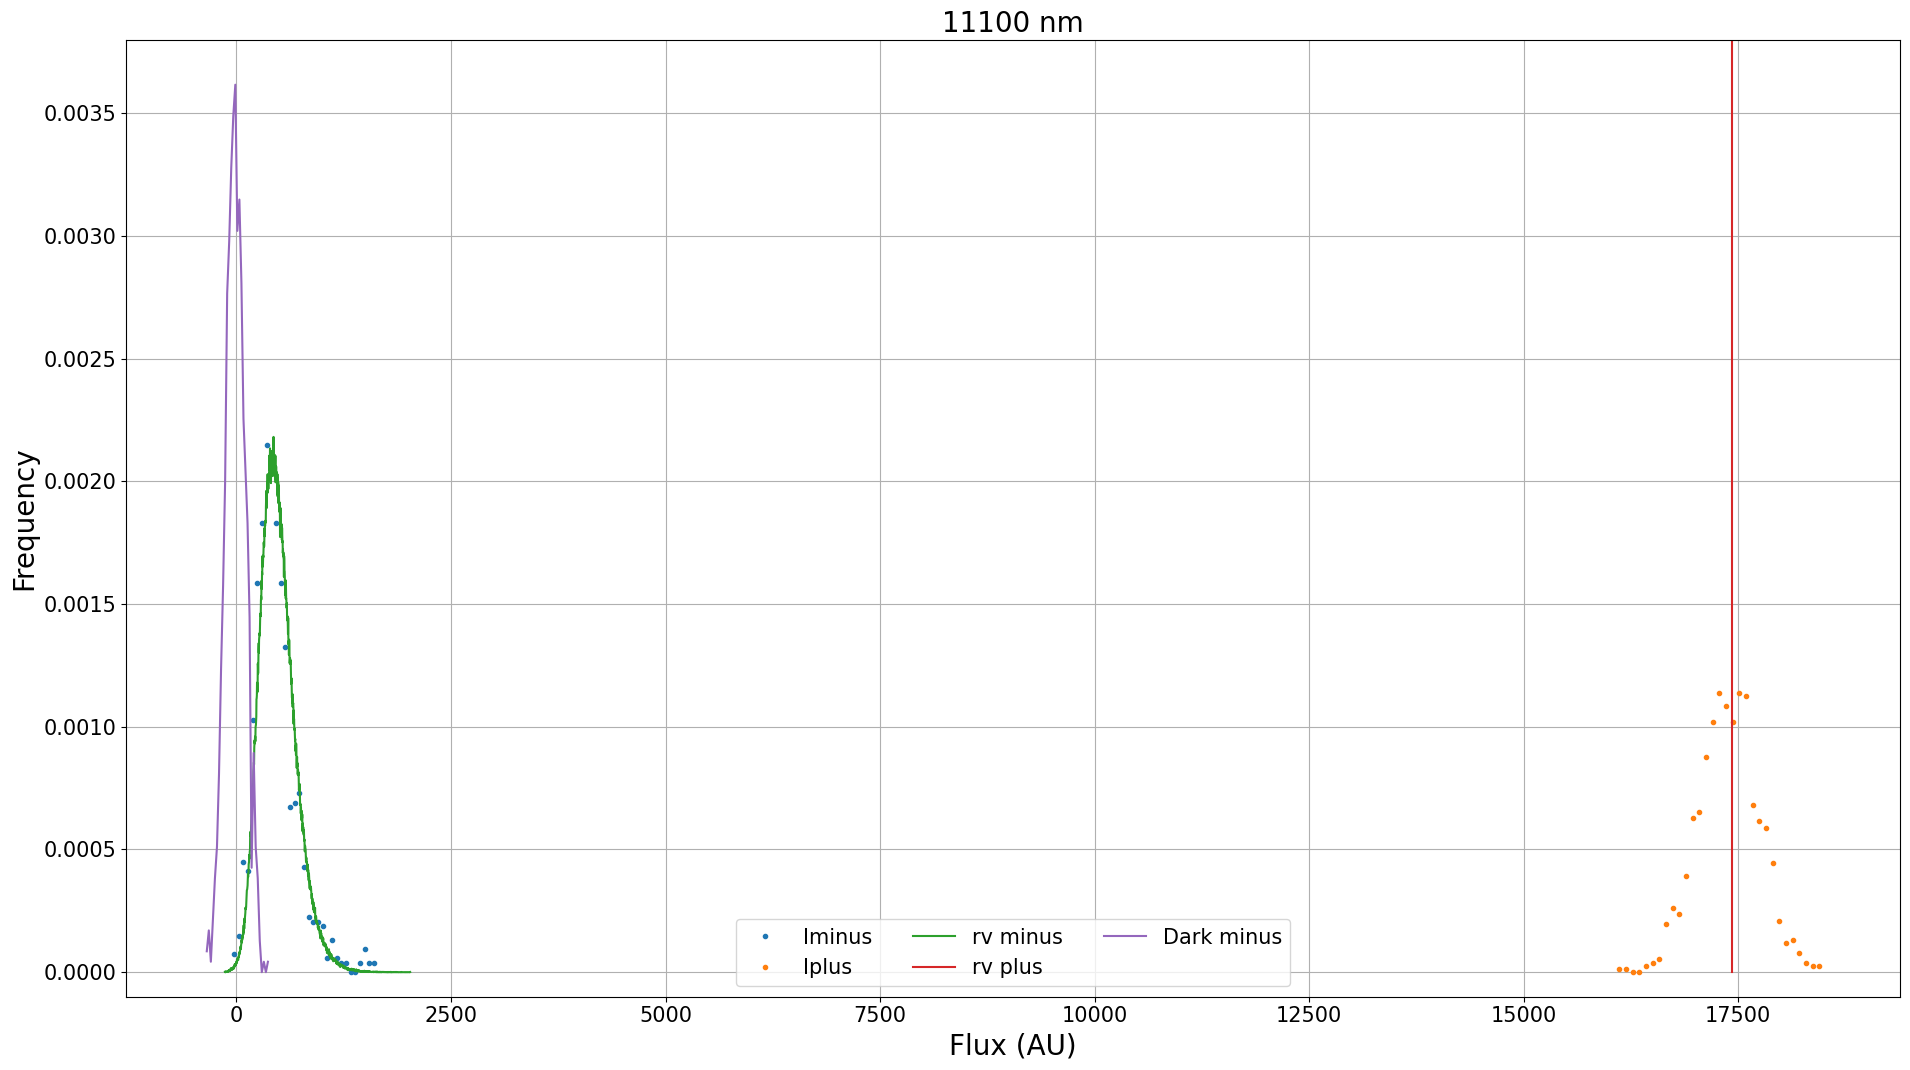

In [18]:
# Diagnostic on the synthetic sequence of nulled and anti-nulled signal
data_to_plot = ((histom, histop), (histom2, histop2), (histodkm,)) # Each sub-tuple will be plot with the same marker. 
labels = (('Iminus', 'Iplus'), ('rv minus', 'rv plus'), ('Dark minus',))
markers = ['.', '-', '-']
save_name = key +\
    '_details_' + str(wl_min) + '-' + str(wl_max) + '_' +\
    os.path.basename(datafolder[:-1])
grip.plot_diag_spectral_data(nb_rows_plot, wl_scale, data_to_plot, labels, save_path, \
                    save_name, markers, save_fig=True)

It is clear that the histograms of the real and synthetic values of the nulled signal superimposed well, strengthening the confidence into estimating the null depth at 0.063.

The anti-null statistics have the same average, the measurements were artificially created from the photometries and the model considered the photometric fluxes to be constant.

What about the injection and the spectral photometries? These are non-spectral data.
We will use `grip.plot_diag_nonspectral_data`.
The interface and the reasoning is the same as for `grip.plot_diag_spectral_data`.


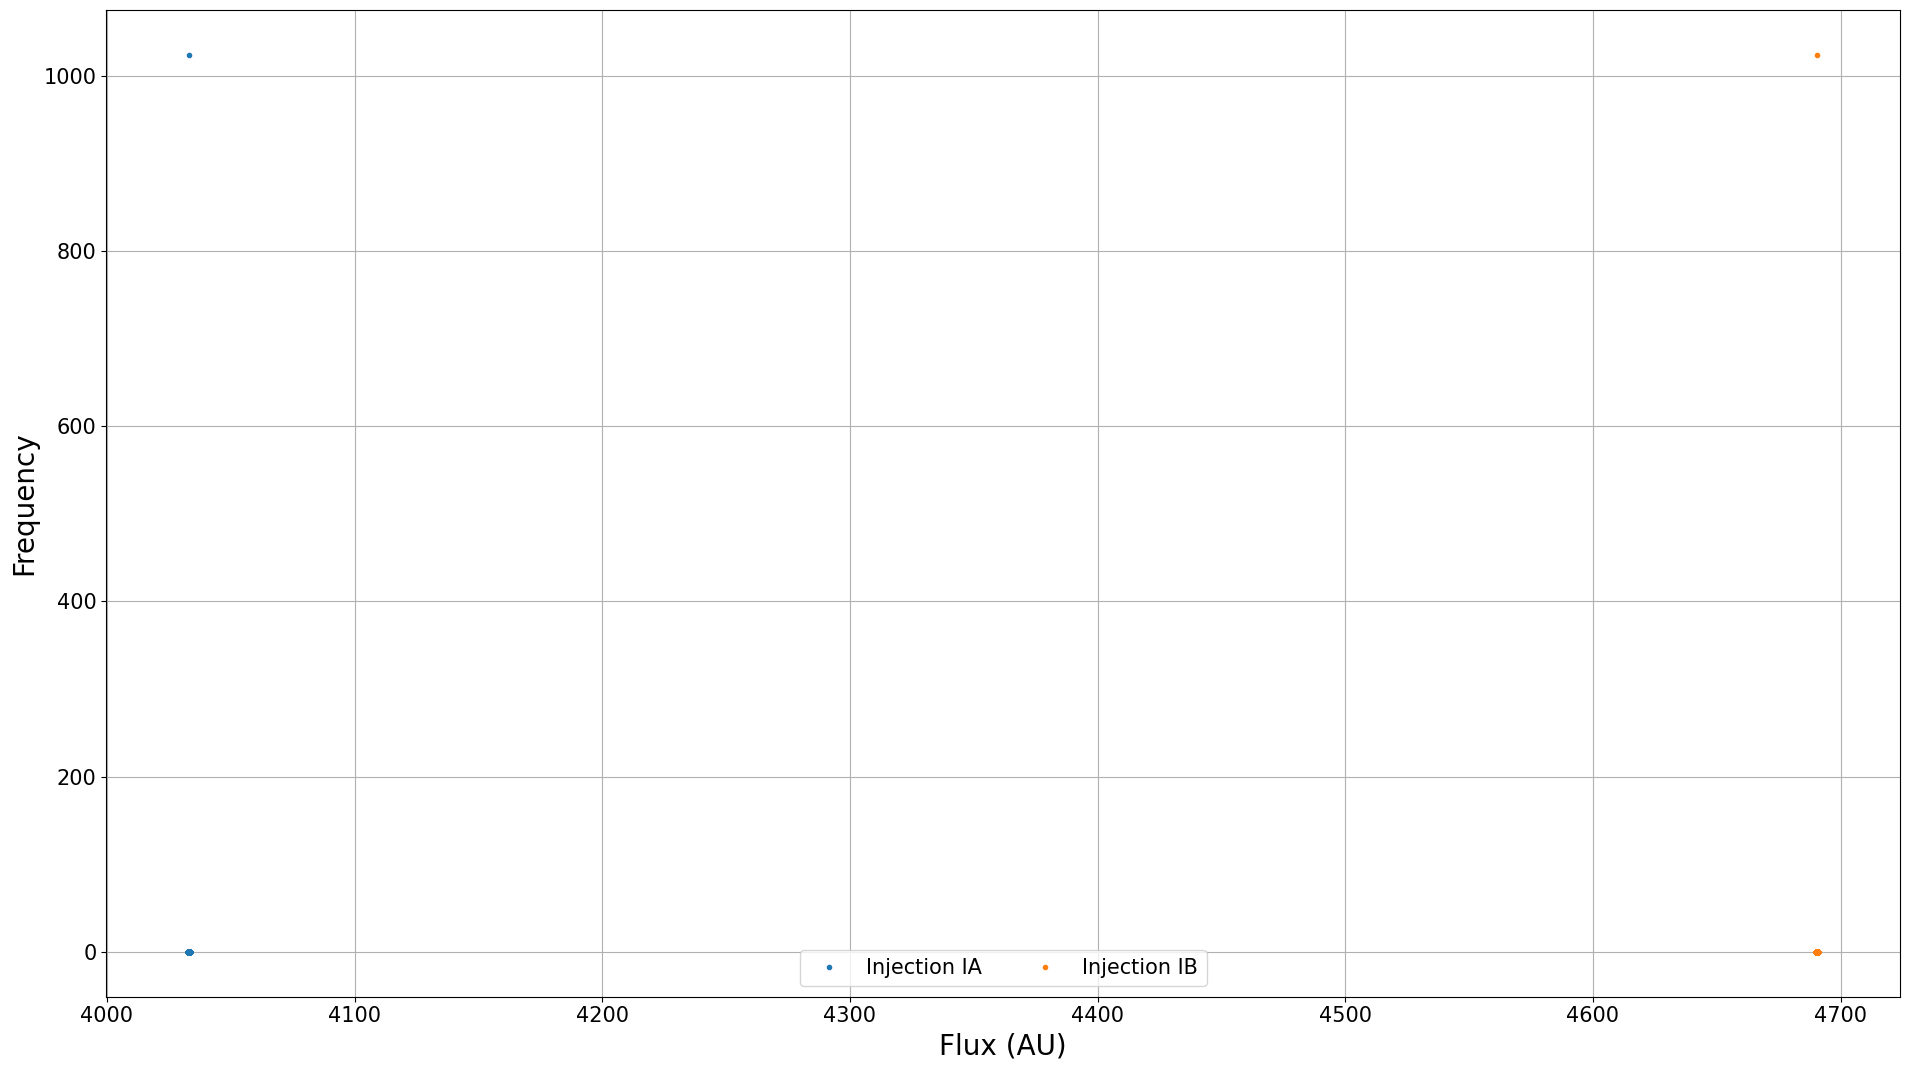

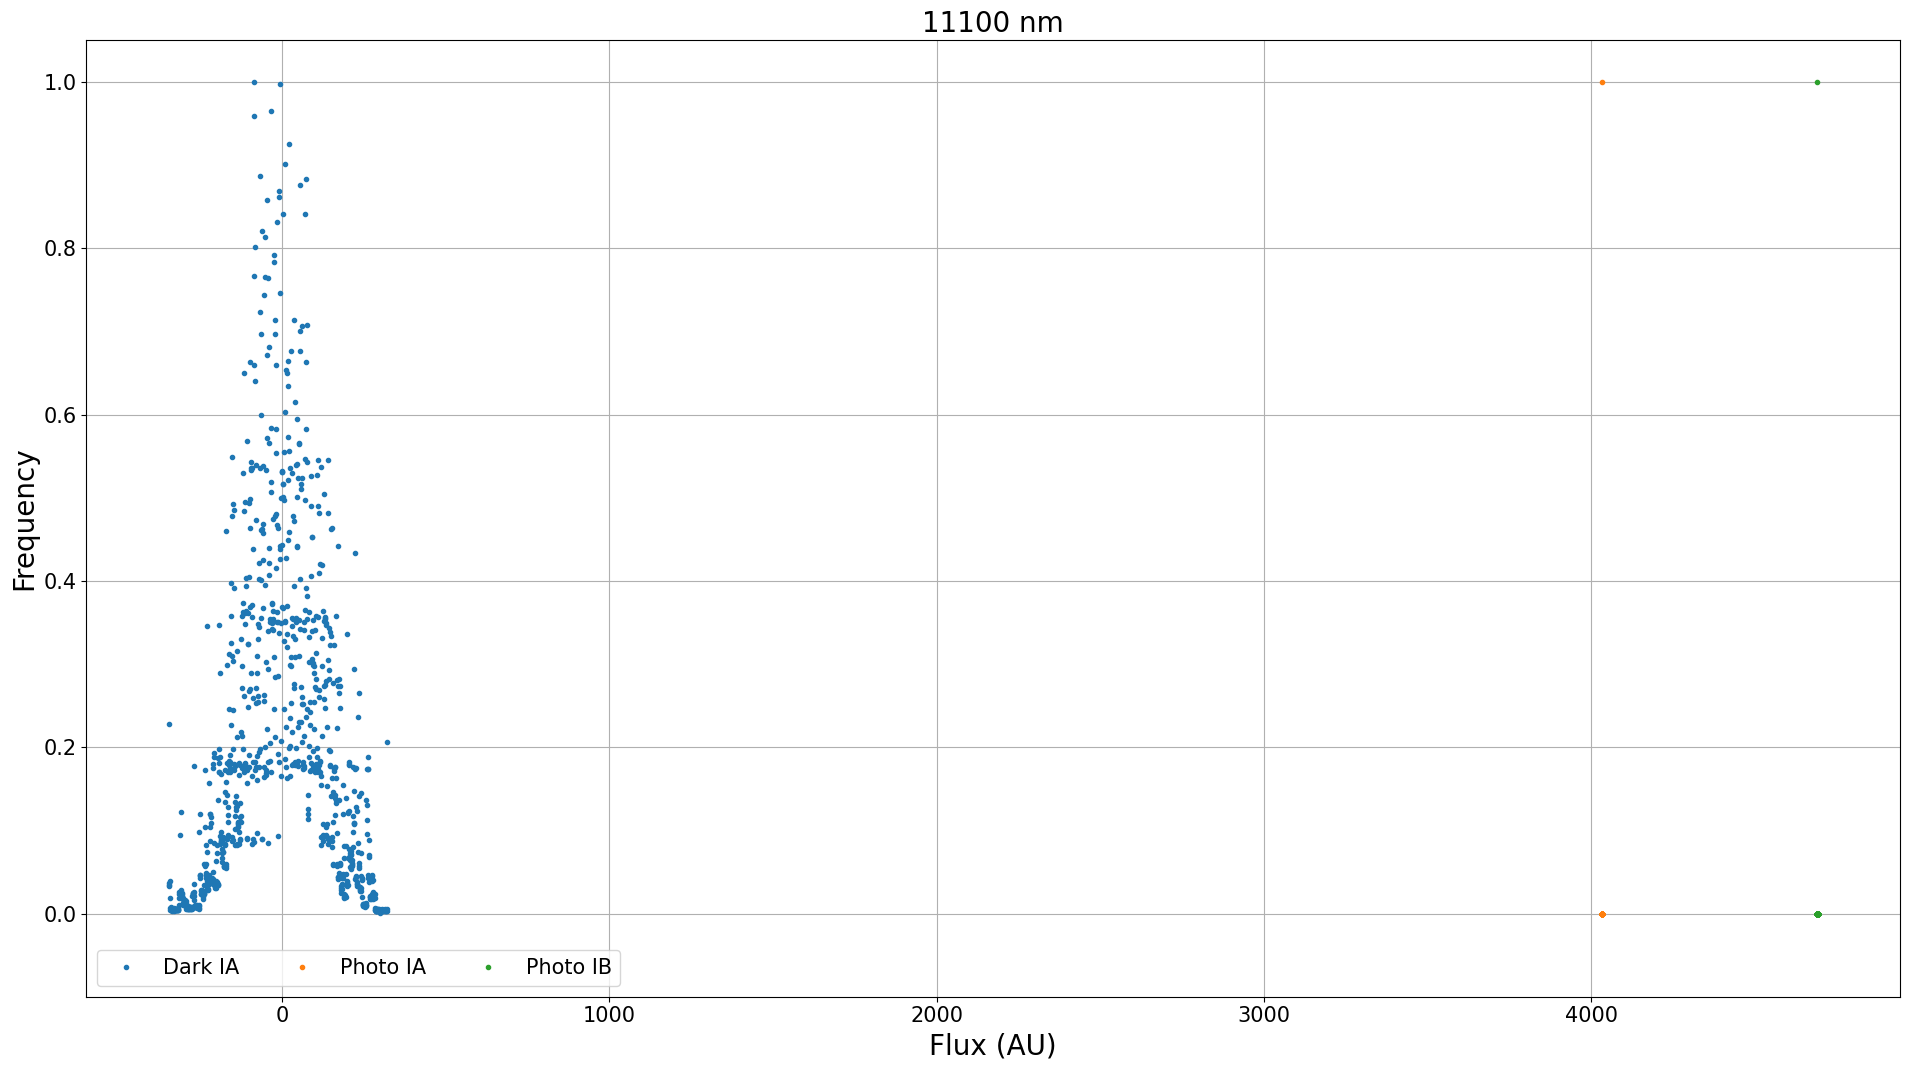

In [19]:
# Diagnostic on the injection
histo_IA = list(np.histogram(diag_IA, bins=int(diag_IA.size**0.5), density=True)[::-1])
histo_IA[0] = histo_IA[0][:-1]
histo_IB = list(np.histogram(diag_IB, bins=int(diag_IB.size**0.5), density=True)[::-1])
histo_IB[0] = histo_IB[0][:-1]
markers = ['.']
data_to_plot = ((histo_IA, histo_IB),)
labels = [('Injection IA', 'Injection IB')]
save_name = key +\
    '_injection_' + str(wl_min) + '-' + str(wl_max) + '_' +\
    os.path.basename(datafolder[:-1])

grip.plot_diag_nonspectral_data(data_to_plot, labels, save_path, \
                    save_name, markers=markers, save_fig=True)

# Diagnostic on the photometries
histodkIA = [np.histogram(diag_dkIA[k], bins=int(
    diag_dkIA[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histodkIA = [(elt[0][:-1], elt[1]/elt[1].max()) for elt in histodkIA]

diag_pA = diag_IA[None,:] * spectra[0][:, None]
diag_pB = diag_IB[None,:] * spectra[1][:, None]

histopA = [np.histogram(diag_pA[k], bins=int(
    diag_pA[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histopA = [(elt[0][:-1], elt[1]/elt[1].max()) for elt in histopA]
histopB = [np.histogram(diag_pB[k], bins=int(
    diag_pB[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histopB = [(elt[0][:-1], elt[1]/elt[1].max()) for elt in histopB]

markers = ['.', '.']
data_to_plot = [(histodkIA,), (histopA, histopB)]
labels = [('Dark IA',), ('Photo IA', 'Photo IB')]
save_name = key +\
    '_photometries_' + str(wl_min) + '-' + str(wl_max) + '_' +\
    os.path.basename(datafolder[:-1])

grip.plot_diag_spectral_data(nb_rows_plot, wl_scale, data_to_plot, labels, \
                    save_path, save_name, markers, save_fig=True)

### Congratulations, we made it until here!

### We know how to use the basic tools of GRIP to load data, pre-process them, use a model and display the result and the diagnostic data.